# DarkELF multiphonon notebook

This notebook is meant to illustrate the part of the darkELF package for calculating dark matter-phonon rates in the multiphonon regime.

written by Ethan, updated 02/08/2021

In [1]:
%matplotlib inline

import sys, os
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pandas
from scipy import interpolate

# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=15)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=15)

# this needs to point to the folder where darkelf.py is stored
work_dir = os.getcwd()
sys.path.append(work_dir+"/..")
plotdir=work_dir+"/plots/"

# load the package
from darkelf import darkelf, targets

## Load the materials

When loading the materials, the "dos_filename" flag must be set in order to calculate rates in the multiphonon regime. The "target_yaml" flag is set automatically and can be overridden. Auxiliary functions "Fn" are pre-tabulated corresponding to the given density of states files and loaded in by default. If using another density of states, one must first run the "create_Fn_omega()" function on the desired density of states.

In [2]:
targets.files('Si')


Available configuration files: 
	 Si.yaml
 
Available data for epsilon: 
	 Si_Migdal_FAC.dat
	 Si_atomic_Z_eps_form_factor.dat
	 Si_mermin.dat
	 Si_gpaw_noLFE.dat
	 Si_gpaw_withLFE.dat
	 Si_epsphonon_theory6K.dat
	 Si_epsphonon_data6K.dat
 
Available data for phonon density of states: 
	 Si_DoS.dat
 
Available data for Fn(omega) functions: 
	 Si_Fn.dat
 
Available data for form factors: 
	 Si_atomic_Z_eps_form_factor.dat


If one is only interested in the multiphonon response, the electronic response specified with the "filename" flag is not used. If it is not specified, the code will produce a warning message, as seen below. There's also an optional form_factor_filename if one is interested in using a custom DM-atomic form factor. These can be ignored as long as we only care about DM-multiphonon scattering. Let's load a few materials.

In [3]:
gaas = darkelf(target='GaAs',dos_filename="GaAs_DoS.dat")
si = darkelf(target='Si',dos_filename="Si_DoS.dat")
c = darkelf(target='C',dos_filename="C_DoS.dat")

 .... Loading files for GaAs
Warning! Epsilon grid in electron regime does not exist.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Warning! Atomic Migdal calculation not present
Loaded GaAs_DoS.dat for density of states
Loaded Fn(omega) functions corresponding to density of states in:  GaAs_DoS.dat
Warning! Form factor not loaded. Need to set form_factor_filename if needed. Otherwise defaults to massive mediator 
 .... Loading files for Si
Warning! Epsilon grid in electron regime does not exist.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Loaded Si_DoS.dat for density of states
Loaded Fn(omega) functions corresponding to density of states in:  Si_DoS.dat
Warning! Form factor not loaded. Need to set form_factor_filename if needed. Otherwise defaults to massive mediator 
 .... Loading files for C
Warning! Epsilon grid in electron regime does not exist.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filen

# Cross section plots

Now using the sigma_nucleon function to calculate the required DM-nucleon cross-section for a rate of 3 events/kg/yr, the larger dark matter mass points take longer to calculate since the integral over the allowed phase space is larger and requires more numerically intensive integrations.

Points 0 to 4 took 0.05939006805419922 seconds to calculate
Points 5 to 9 took 0.11327791213989258 seconds to calculate
Points 10 to 14 took 33.545820236206055 seconds to calculate
Points 15 to 19 took 67.87384700775146 seconds to calculate
Points 20 to 24 took 63.21372389793396 seconds to calculate
Points 25 to 29 took 68.51067614555359 seconds to calculate
Points 30 to 34 took 72.39630699157715 seconds to calculate
Points 35 to 39 took 67.0832462310791 seconds to calculate


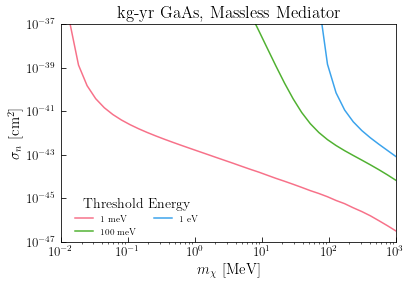

In [4]:
import seaborn as sns

points = 40

mdm = np.logspace(4, 9, points)

reaches1 = np.zeros(points)
reaches2 = np.zeros(points)
reaches3 = np.zeros(points)

import time

for i, mass in enumerate(mdm):
    if (i % 5) == 0:
        start = time.time()
    reaches1[i] = gaas.sigma_nucleon(mass, 1e-3, mediator='massless')
    reaches2[i] = gaas.sigma_nucleon(mass, 1e-1, mediator='massless')
    reaches3[i] = gaas.sigma_nucleon(mass, 1, mediator='massless')

    if (i % 5) == 4:
        end = time.time()
        print(f'Points {i - 4} to {i} took {end - start} seconds to calculate')
        # Just to check that everything is still working, the later points
        # take longer
        
colors = sns.color_palette("husl", 3)

fig, ax = plt.subplots()


ax.plot(mdm/1e6, reaches1, label='$1$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$100$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$1$ eV', color=colors[2])


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel('$\sigma_n \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

ax.set_title(r'kg-yr GaAs, Massless Mediator')

ax.set_xlim([1e-2,1e3])
ax.set_ylim([1e-47,1e-37])

xtick_major = [pow(10.,n) for n in range(-2,4,1)]
ytick_major = [pow(10.,n) for n in range(-47,-36,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.legend(loc=(0.03,0.01),fontsize=9,frameon=False,ncol=2,title='Threshold Energy')

plt.savefig(plotdir+"gaas_massless_multiphonon.pdf",bbox_inches='tight')


If starting with a new density of states, one must run the 'create_Fn_omega()' function. This defaults to creating the Fn functions corresponding to the density of states loaded in in the instantiation of the class. This can take an hour or two.

# Differential Rate $\frac{dR}{d\omega}$

We can calculate the differential rate as a function of the incoming dark matter mass using the function 'dR_domega_multiphonons' (defaults to coupling with mass number and $\sigma_n = 10^{-38} \mathrm{cm}^2$). Note that the single optical phonon response in the long wavelength regime we model as a Gaussian with width 0.5 meV

/Users/ethanvillarama/Desktop/phonon/python/DarkELF-main/examples/../darkelf/multiphonon_generalized.py:273: RuntimeWarning: invalid value encountered in double_scalars
  formfactorsquared*debye_waller*self.etav((omega/self.cLA)/(2*mdm) + omega/(omega/self.cLA)))


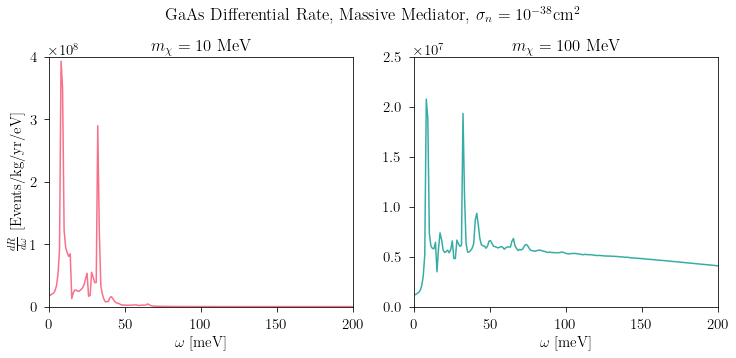

In [5]:
import seaborn as sns

mdm1 = 1e7
mdm2 = 1e8

omegarange = np.linspace(0, 200e-3, 200)

dr_domega1 = [gaas.dR_domega_multiphonons(mdm1, omega, mediator='massive') for omega in omegarange]
dr_domega2 = [gaas.dR_domega_multiphonons(mdm2, omega, mediator='massive') for omega in omegarange]

colors = sns.color_palette("husl", 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.6))

ax1.plot(omegarange*1e3, dr_domega1, color=colors[0])
ax2.plot(omegarange*1e3, dr_domega2, color=colors[1])


ax1.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax2.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax1.set_ylabel(r'$\frac{dR}{d\omega} \ [\mathrm{Events}/\mathrm{kg}/\mathrm{yr}/\mathrm{eV}]$',fontsize=15)


ax1.set_title(r'$m_\chi = 10$ MeV')
ax2.set_title(r'$m_\chi = 100$ MeV')

ax1.set_xlim([0,200])
ax2.set_xlim([0,200])

ax1.set_ylim([0,4e8])
ax2.set_ylim([0,2.5e7])


xtick_major = [50*n for n in range(5)]
ytick_major = [1e8*n for n in range(5)]
ax1.set_yticks(ytick_major)

ax1.set_xticks(xtick_major)
ax2.set_xticks(xtick_major)

ytick_major = [0.5e7*n for n in range(6)]
ax2.set_yticks(ytick_major)

plt.suptitle(r'GaAs Differential Rate, Massive Mediator, $\sigma_n = 10^{-38} \mathrm{cm}^2$', y=1.03)

plt.savefig(plotdir+"gaas_massive_rates.pdf",bbox_inches='tight')

# Custom Atomic Form Factor

Here we calculate the cross-section for a rate of 3 events/kg/yr for a dark photon, using a custom atomic form factor. In order to do this, the form factor must be loaded in at the instantiation of the class via 'form_factor_filename' and the flag 'custom_form_factor' must be set to 'True' in function calls. Note that the default coupling without a custom form factor is the mass number, setting 'custom_form_factor' to 'True' removes the mass number coupling.

 .... Loading files for Si
Warning! Epsilon grid in electron regime does not exist.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Loaded Si_DoS.dat for density of states
Loaded Fn(omega) functions corresponding to density of states in:  Si_DoS.dat
Loaded Si_atomic_Z_eps_form_factor.dat for form factor
Points 0 to 4 took 0.03877687454223633 seconds to calculate
Points 5 to 9 took 0.09177422523498535 seconds to calculate
Points 10 to 14 took 30.830400943756104 seconds to calculate
Points 15 to 19 took 108.66565299034119 seconds to calculate
Points 20 to 24 took 77.96392226219177 seconds to calculate
Points 25 to 29 took 69.02868103981018 seconds to calculate
Points 30 to 34 took 73.16065621376038 seconds to calculate
Points 35 to 39 took 70.12391996383667 seconds to calculate


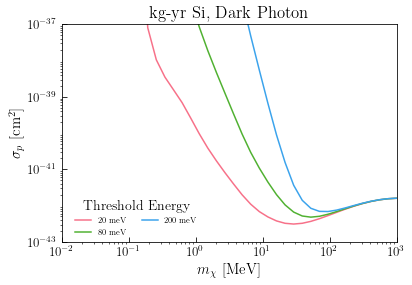

In [6]:
import seaborn as sns

# Loads dark photon form factor 
si = darkelf(target='Si',dos_filename="Si_DoS.dat",
             form_factor_filename='Si_atomic_Z_eps_form_factor.dat')

points = 40

mdm = np.logspace(4, 9, points)

reaches1 = np.zeros(points)
reaches2 = np.zeros(points)
reaches3 = np.zeros(points)


import time

for i, mass in enumerate(mdm):
    if (i % 5) == 0:
        start = time.time()
    reaches1[i] = si.sigma_nucleon(mass, 20e-3, custom_form_factor=True)
    reaches2[i] = si.sigma_nucleon(mass, 80e-3, custom_form_factor=True)
    reaches3[i] = si.sigma_nucleon(mass, 200e-3, custom_form_factor=True)

    if (i % 5) == 4:
        end = time.time()
        print(f'Points {i - 4} to {i} took {end - start} seconds to calculate')
        # Just to check that everything is still working, the later points
        # take longer
        
colors = sns.color_palette("husl", 3)

fig, ax = plt.subplots()

ax.plot(mdm/1e6, reaches1, label='$20$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$80$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$200$ meV', color=colors[2])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1e-2,1e3])
ax.set_ylim([1e-43,1e-37])

ax.set_xlabel('$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel('$\sigma_p \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

xtick_major = [pow(10.,n) for n in range(-2,4,1)]
ytick_major = [pow(10.,n) for n in range(-43,-36,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.set_title(r'kg-yr Si, Dark Photon')

ax.legend(loc=(0.03,0.01),fontsize=8,frameon=False,ncol=2,title="Threshold Energy",)

plt.savefig(plotdir+"si_dark_photon.pdf",bbox_inches='tight')
